In [9]:
import torch 
import numpy as np
import os 
from utils.config import get_dataset_path
from utils.data_names import mesh_file_name
from utils.utils_func import batchify_dict, convert_dict
from utils.surfaces import Surface, filter_furthest
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from prism_decoder.prism_decoder import PrismDecoder
from prism_decoder.loss import PrismRegularizationLoss
from utils.fmap import KNNSearch, extract_p2p_torch, extract_p2p_torch_fmap, torch_zoomout, soft_knnsearch
import potpourri3d as pp3d
import matplotlib.pyplot as plt 

In [2]:
import meshplot as mp

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def double_plot_surf(surf_1, surf_2,cmap1=None,cmap2=None):
    d = mp.subplot(surf_1.vertices, surf_1.faces, c=cmap1, s=[2, 2, 0])
    mp.subplot(surf_2.vertices, surf_2.faces, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

def visu_pts(surf, idx_points, colors):
    solver = pp3d.MeshHeatMethodDistanceSolver(surf.vertices, surf.faces)
    color_array = np.zeros(surf.vertices.shape)
    for i in range(len(idx_points)):
        i_v = idx_points[i]
        dist = solver.compute_distance(i_v)*2
        color_array += np.clip(1-dist, 0, np.inf)[:, None]*colors[i][None, :]
    color_array = np.clip(color_array, 0, 255.)
    return color_array

def visu_seg(surf, idx, colors):
    solver = pp3d.MeshHeatMethodDistanceSolver(surf.vertices, surf.faces)
    color_array = np.zeros(surf.vertices.shape)
    for i in range(idx.max()+1):
        color_array[idx==i] = colors[i]
    color_array = np.clip(color_array, 0, 255.)
    return color_array

colors = np.array([[255, 119, 0], #orange
                           [163, 51, 219], #violet
                           [0, 246, 205], #bleu clair
                           [0, 131, 246], #bleu floncé 
                           [246, 234, 0], #jaune
                           [255, 0, 0]]) #rouge

In [3]:
## Feature extractor parameters

from fmap_model import DQFMNet
cfg = {"fmap": {"n_fmap": 30, "n_cfmap": 0, "C_in": 3, "n_feat": 128,
                "lambda_": 1000, "resolvant_gamma": 0.5, "robust": False},
       "feat": "xyz"}
n_fmap = cfg['fmap']['n_fmap']
device = "cuda"


## Shape encoder
from diffusion_net.layers import DiffusionNet

class Encoder(nn.Module):
    def __init__(self, with_grad=True):
        super(Encoder, self).__init__()
        self.diff_net = DiffusionNet(
             C_in=3,
             C_out=512,
             C_width=128,
             N_block=4,
             dropout=True,
             with_gradient_features=with_grad,
             with_gradient_rotations=with_grad,
        )

    def forward(self, shape_dict):
        feats = self.diff_net(shape_dict["vertices"], shape_dict["mass"], shape_dict["L"], evals=shape_dict["evals"], 
                               evecs=shape_dict["evecs"], gradX=shape_dict["gradX"], gradY=shape_dict["gradY"], faces=shape_dict["faces"])
        x_out = torch.max(feats, dim=0).values
        return x_out

In [4]:
## Utils to load meshes and stuff

from diffusion_net.operators import compute_operators, load_operators
from utils.mesh import load_mesh, opt_rot_points_torch

cache = os.path.join("cache/snk")
os.makedirs(cache, exist_ok=True) 

def load_data(file, cache_file, name, num_evecs=128, make_cache=False):
    verts_shape, faces, vnormals, area_shape, center_shape = load_mesh(file, return_vnormals=True)
    cache_path = os.path.join(cache, cache_file)
    if not os.path.exists(cache_path) and (not make_cache):
        compute_operators(verts_shape, faces, vnormals, num_evecs, cache_path)
    data_dict = load_operators(cache_path)
    data_dict['name'] = name
    data_dict_torch = convert_dict(data_dict, device)
    #batchify_dict(data_dict_torch)
    return data_dict_torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
##Routine to load data: select dataset, idx
dataset = "SHREC"
idx_1, idx_2 = 25, 16 

#Then the script loads (need to configure properly config.yml)
data_path = os.path.join(get_dataset_path(dataset, True))

file_1 = mesh_file_name(idx_1, dataset)
shape_dict = load_data(os.path.join(data_path, file_1), file_1.replace(".ply", ".npz"), idx_1)
shape_surf = Surface(filename=os.path.join(data_path, file_1))
n_verts_1 = shape_dict["vertices"].shape[0]
## Just for color transfer vizualization (needs to be rewritten, sometimes it just doesn't work)
idx, C, _, _ = shape_surf.laplacianSegmentation(6)
new_idx, matches, matches_init = filter_furthest(shape_surf, idx, C)


file_2 = mesh_file_name(idx_2, dataset)
target_dict = load_data(os.path.join(data_path, file_2), file_2.replace(".ply", ".npz"), idx_2)
target_surf = Surface(filename=os.path.join(data_path, file_2))
n_verts_2 = target_dict["vertices"].shape[0]
target_normals = torch.from_numpy(target_surf.surfel/np.linalg.norm(target_surf.surfel, axis=-1, keepdims=True)).float().cuda()


## Rotationally align, otherwise it won't work (see details of paragraph 5.1)
if dataset == "SCAPE":
    file_vts_1 = os.path.join(data_path, "corres", file_1.replace(".ply", ".vts"))
    vts_1 = np.loadtxt(file_vts_1).astype(np.int32) - 1

    file_vts_2 = os.path.join(data_path, "corres", file_2.replace(".ply", ".vts"))
    vts_2 = np.loadtxt(file_vts_2).astype(np.int32) - 1

    pts_1, pts_2 = shape_dict['vertices'][vts_1], target_dict['vertices'][vts_2]
    rot = opt_rot_points_torch(pts_1, pts_2, device)
    target_dict['vertices'] = target_dict['vertices'] @ rot
    target_surf.updateVertices(target_surf.vertices @ rot.detach().cpu().numpy())
elif dataset == "SHREC":
    map_file = os.path.join(data_path, "groundtruth", f"{idx_2}_{idx_1}.map")
    if os.path.exists(map_file):
        map_idx = np.loadtxt(map_file).astype(np.int32) - 1
        pts_1, pts_2 = shape_dict['vertices'][map_idx], target_dict['vertices']
        rot = opt_rot_points_torch(pts_1, pts_2, device)
        target_dict['vertices'] = target_dict['vertices'] @ rot
        target_surf.updateVertices(target_surf.vertices @ rot.detach().cpu().numpy())
    else:
        print("NO MAP GROUND TRUTH, IMPOSSIBLE TO ALIGN")

[5.21196601e-05 4.35774369e+00 5.51596582e+00 8.86826486e+00
 1.30050235e+01 1.74668406e+01 3.32869170e+01 3.67863619e+01
 5.35464692e+01 5.55141564e+01 7.69785071e+01 8.60087763e+01]


/home/emerypierson/Documents/snk_fmap/utils/surfaces.py:200: RuntimeWarning: invalid value encountered in divide
  normals /= af.reshape([self.vertices.shape[0], 1])


[[ 0.14432073 -0.0627251  -0.10617655]] [0] [268]


In [17]:
## Model initialization
encoder = Encoder().to(device)
net = DQFMNet(cfg).to(device)
decoder = PrismDecoder(dim_in=515).to(device)
loss_prism = PrismRegularizationLoss(primo_h=0.02)
C12_pred_init, C21_pred_init, Q_pred, feat1, feat2, evecs_trans1, evecs_trans2, evecs1, evecs2 = net({"shape1": shape_dict, "shape2": target_dict})

In [18]:
## Optimization init
params_to_opt = list(net.parameters()) + list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.Adam(params_to_opt, lr=0.001, betas=(0.9, 0.99))

eye = torch.eye(cfg["fmap"]["n_fmap"]).float().cuda() # For fmap loss
eye.requires_grad = False
n_loop = 1000
loss_save = {"cycle": [], "fmap": [], "mse": [], "prism": []}

In [19]:
for i_iter in tqdm(range(n_loop), "optimizing"):
    ## Computing maps 
    C12_pred, C21_pred, Q_pred, feat1, feat2, evecs_trans1, evecs_trans2, evecs1, evecs2 = net({"shape1": shape_dict, "shape2": target_dict})
    
    ## P2P 2 -> 1
    soft_p2p_21 = soft_knnsearch(evecs2[:, :n_fmap] @ C12_pred.squeeze(), evecs1[:, :n_fmap])
    C12_new = evecs_trans2[:n_fmap, :] @ soft_p2p_21 @ evecs1[:, :n_fmap]
    soft_p2p_21 = soft_knnsearch(evecs2[:, :n_fmap] @ C12_new.squeeze(), evecs1[:, :n_fmap])

    ## P2P 1 -> 2 
    soft_p2p_12 = soft_knnsearch(evecs1[:, :n_fmap] @ C21_pred.squeeze(), evecs2[:, :n_fmap])
    C21_new = evecs_trans1[:n_fmap, :] @ soft_p2p_12 @ evecs2[:, :n_fmap]
    soft_p2p_12 = soft_knnsearch(evecs1[:, :n_fmap] @ C21_new.squeeze(), evecs2[:, :n_fmap])

    # Latent vector 
    latents = encoder(shape_dict)
    latents_duplicate = latents[None, :].repeat(n_verts_2, 1)

    # Prism decoder
    feats_decode = torch.cat((target_dict["vertices"], latents_duplicate), dim=1)
    output, prism, rots = decoder(target_dict, feats_decode)

    ## losses 
    l_prism = loss_prism(prism, rots, target_dict["vertices"], target_dict["faces"], target_normals)
    l_mse = ((soft_p2p_21 @ shape_dict["vertices"] - output)**2).sum(dim=-1).mean()
    l_fmap = ((C21_new.squeeze() @ C12_new.squeeze() - eye)**2).sum() + ((C12_new.squeeze() @ C12_new.squeeze().T - eye)**2).sum()
    l_fmap += ((C12_new.squeeze() @ C21_new.squeeze() - eye)**2).sum() + ((C21_new.squeeze() @ C21_new.squeeze().T - eye)**2).sum()
    l_cycle = ((soft_p2p_12 @ (soft_p2p_21 @ shape_dict["vertices"]) - shape_dict["vertices"])**2).sum(dim=-1).mean()

    loss = l_mse + l_fmap + l_cycle + l_prism
    loss.backward()
    optim.step()
    optim.zero_grad()

    loss_save["cycle"].append(l_cycle.item())
    loss_save["fmap"].append(l_fmap.item())
    loss_save["mse"].append(l_mse.item())
    loss_save["prism"].append(l_prism.item())

optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
indKNN_new, indKNN_2_new = extract_p2p_torch_fmap(C12_pred_init, evecs1, evecs2)
cmap1 = visu_pts(shape_surf, matches_init, colors)
cmap2 = cmap1[indKNN_new]
double_plot_surf(target_surf, shape_surf,cmap2/255., cmap1/255.)

In [21]:
indKNN_new, indKNN_2_new = extract_p2p_torch_fmap(C12_new, evecs1, evecs2)
## You can remove comments if you want to test zoomout (and put indKNN_new_zo in place for cmap2)
# evecs_2trans = evecs2.t() @ torch.diag(target_dict["mass"])
# print(evecs_2trans.shape, C12_pred.shape)
# new_FM = torch_zoomout(evecs1, evecs2, evecs_2trans, C12_pred.squeeze(), 150)
# indKNN_new_zo, indKNN_2_new_zo = extract_p2p_torch_fmap(new_FM, evecs1, evecs2)
cmap1 = visu_pts(shape_surf, matches_init, colors)
cmap2 = cmap1[indKNN_new]

#double_plot_surf(surf_template, surf_template,cmap2/255., cmap3/255.)
double_plot_surf(target_surf, shape_surf,cmap2/255., cmap1/255.)

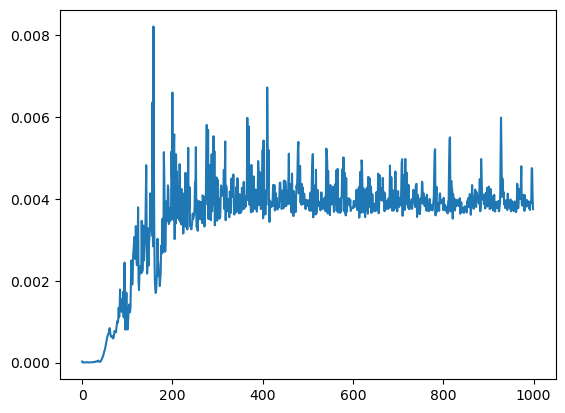

In [14]:
## Check losses
plt.plot(loss_save['prism'])
plt.show()

In [22]:
## Check meshes from the loop

from ipygany import PolyMesh, Scene
mesh_1 = PolyMesh(
    vertices=output.detach().cpu().numpy(),
    triangle_indices=target_surf.faces
)
mesh_1.default_color = 'gray'

mesh_2 = PolyMesh(
    vertices=(soft_p2p_21 @ shape_dict["vertices"]).detach().cpu().numpy(),
    triangle_indices=target_surf.faces
)
mesh_2.default_color = 'tomato'

mesh_3 = PolyMesh(
    vertices=shape_surf.vertices,
    triangle_indices=shape_surf.faces
)
mesh_3.default_color = 'orange'

mesh_4 = PolyMesh(
    vertices=target_surf.vertices,
    triangle_indices=target_surf.faces
)
mesh_4.default_color = 'green'

scene = Scene([mesh_1])
scene = Scene([mesh_1, mesh_3])
scene

Scene(children=[PolyMesh(data=[], default_color='gray', triangle_indices=array([   5,  322, 2897, ..., 5198, 4…